In [1]:
%load_ext autoreload
%autoreload 2

import os

import pandas as pd
from pytorch_lightning import Trainer
from pl_module import CMPNNLitModel, MultiCMPNNLitModel
from dataset import CMPNNDataset, MultiCMPNNDataset, MultiCMPNNDatasetSDF, CMPNNDataModule
from preprocessing import scaffold_split_indices, random_split_indices
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from torch.utils.data import Subset
from global_feat import CompositeGlobalFeaturizer, MorganBinaryFeaturizer, RDKit2DNormalizedFeaturizer

In [2]:
sdf_path = '/home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data'
target_data = '/home/calvin/code/chemprop_phd_customised/habnet/data/processed/target_data/kinetics_summary.csv'
assert os.path.exists(sdf_path), f"SDF path does not exist: {sdf_path}"
assert os.path.exists(target_data), f"Target data file does not exist: {target_data}"

In [3]:
out_csv   = '/home/calvin/code/chemprop_phd_customised/habnet/data/processed/target_data/temp_target_kinetic_data.csv'


In [4]:
root = "."
sdf_dir = "/home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/"
targets = out_csv
target_cols  = ['A_log10','n', 'Ea_yj']
target_types = {'A_log10': 'continuous', 'n': 'continuous', 'Ea_yj': 'continuous'}

In [5]:

ds = MultiCMPNNDatasetSDF(
    root,
    sdf_files=sdf_dir,
    target_df=targets,
    target_cols=target_cols,
    target_types=target_types,
    atom_messages=True,
    keep_hs=True,
    sanitize=False,
    force_reload=True,
    prune_value=-10,
    # global_featurizer= CompositeGlobalFeaturizer(
    #     featurizers=[
    #         MorganBinaryFeaturizer(radius=2, length=2048),
    #         RDKit2DNormalizedFeaturizer(),
    #     ]
    # ),
    # pre_transform=PeriodicToSinCosGaussianJitter(target_cols, target_types, radians = False, ignore_val=-10, max_jitter_deg = 10)
)

Processing...
/home/calvin/code/vibe_cmpnn/dataset.py:514: UserWarning: No target row for reaction 'rmg_rxn_1130' – skipped
  warnings.warn(f"No target row for reaction '{rxn}' – skipped")
/home/calvin/code/vibe_cmpnn/dataset.py:514: UserWarning: No target row for reaction 'rmg_rxn_1141' – skipped
  warnings.warn(f"No target row for reaction '{rxn}' – skipped")
/home/calvin/code/vibe_cmpnn/dataset.py:514: UserWarning: No target row for reaction 'rmg_rxn_1162' – skipped
  warnings.warn(f"No target row for reaction '{rxn}' – skipped")
/home/calvin/code/vibe_cmpnn/dataset.py:514: UserWarning: No target row for reaction 'rmg_rxn_1337' – skipped
  warnings.warn(f"No target row for reaction '{rxn}' – skipped")
/home/calvin/code/vibe_cmpnn/dataset.py:514: UserWarning: No target row for reaction 'rmg_rxn_14' – skipped
  warnings.warn(f"No target row for reaction '{rxn}' – skipped")
/home/calvin/code/vibe_cmpnn/dataset.py:514: UserWarning: No target row for reaction 'rmg_rxn_1454' – skipped
  w

In [6]:
ds[0]

(Data(x=[7, 133], edge_index=[2, 14], edge_attr=[14, 12], y=[3], name='r1h', reaction='kfir_rxn_10218'),
 Data(x=[8, 133], edge_index=[2, 14], edge_attr=[14, 12], y=[3], name='r2h', reaction='kfir_rxn_10218'))

In [7]:
train_idx, val_idx, test_idx = random_split_indices(ds, 0.1, 0.1)

print(f"train: {len(train_idx)}, val: {len(val_idx)}, test: {len(test_idx)}")

train: 1359, val: 170, test: 170


In [8]:
ds.compute_normalization(train_idx)

(tensor([-2.6576e+00,  4.3149e+00,  3.8700e-04]),
 tensor([3.2817, 0.8044, 1.0247]),
 tensor([]))

In [9]:
ds.apply_normalization()

In [10]:
train_ds = Subset(ds, train_idx)
val_ds   = Subset(ds, val_idx)
test_ds  = Subset(ds, test_idx)

In [11]:
from utils_paired import collate_pairs
# Use pytorch pure data loader
from torch.utils.data import DataLoader
# 7) create dataloaders
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=collate_pairs)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, collate_fn=collate_pairs)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, collate_fn=collate_pairs)

In [12]:
from utils_paired import collate_pairs
# Use pytorch pure data loader
from torch.utils.data import DataLoader
# 7) create dataloaders
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=collate_pairs)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, collate_fn=collate_pairs)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, collate_fn=collate_pairs)
sample_pairs = [train_ds[i] for i in range(4)]   # 4 tuple-pairs
batch        = collate_pairs(sample_pairs)       # now returns one Batch
print(type(batch), batch.num_graphs)             # Batch 8

batch.num_graphs
batch.y

<class 'abc.DataBatch'> 8


tensor([[ 0.3258, -0.4802, -0.7364],
        [ 0.3258, -0.4802, -0.7364],
        [-0.6540,  0.5385, -0.0953],
        [-0.6540,  0.5385, -0.0953],
        [ 0.7273, -0.7758, -1.3326],
        [ 0.7273, -0.7758, -1.3326],
        [ 1.3823, -0.9251, -1.1318],
        [ 1.3823, -0.9251, -1.1318]])

In [13]:
from torchmetrics import MeanSquaredError, MeanAbsoluteError, R2Score
# Check device
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
ds.mean

tensor([-2.6576e+00,  4.3149e+00,  3.8700e-04])

In [15]:
ds.std

tensor([3.2817, 0.8044, 1.0247])

In [52]:
from metrics import MSE, RMSE, R2Score, MAE, AngularError, SinCosMSELoss, AngularMSELoss, PinballLoss
print(">>> Model class created")
model = MultiCMPNNLitModel(
    in_node_feats=ds.num_atom_features,
    in_edge_feats=ds.num_bond_features,
    # in_global_feats=ds.global_feature_dim,
    hidden_dim=1024,
    num_steps=3,
    dropout_mp=0.1,
    dropout_head=0.1,
    n_tasks=3,
    #metrics=[AngularError()],
    metrics = [
    MSE (task_weights=[10,1,1]),          # primary mean loss
    PinballLoss(q=0.9, task_weights=[10,1,1], alias='pinball_loss'),
    RMSE([10,1,1]),
    MAE ([10,1,1]),
    R2Score([10,1,1])
],
    lr=1e-4,
    weight_decay=1e-4,
    target_mean=ds.mean,
    target_std=ds.std,
    mpn_shared=True,
    target_types=target_types,
    # ignore_val=-10,
    jitter=False,
    normalize_head=True,
    readout="gru",
    X_d_transform=None,
    mean_dir=ds.per_mean_dir,
    pinball_weight=0.2
)
print(">>> Model instantiated")

>>> Model class created


TypeError: metrics.CMPNNMetric.__init__() got multiple values for keyword argument 'alias'

| **3 · Copy the *same* alias in the full-epoch retrain** | When you build `final_models`, you again set no alias, so it’s now fine—just keep it consistent. | Nothing else to change once fix #1 is applied. |

After those tweaks:

### What will happen

1. **50 trials × 60 epochs**  
   *Optuna + Median pruner + WandB-offline* explore the space quickly.

2. **Top-3 refit × 300 epochs**  
   You rebuild the dataset with the trial’s own `atom_messages`, then train full fidelity. Their fresh `PinballLoss` receives, e.g. `q = 0.87` → alias `pinball_q87`, matching the detection code.

3. **Results**  
   `final_models` holds `(rank, final_val_loss, model)` so you can immediately run `trainer.test(final_models[0][2], test_loader)` or save the checkpoint.

Everything else—dataset caching, offline logging, SQLite storage—works exactly as intended.

Launch the script; if you open another terminal you can watch progress live:

```bash
optuna-dashboard sqlite:///cmpnn_optuna.db
wandb offline view


In [46]:
model

MultiCMPNNLitModel(
  (encoder): CMPNNEncoder(
    (lin_node): Sequential(
      (0): Linear(in_features=133, out_features=1024, bias=True)
      (1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    )
    (lin_edge): Sequential(
      (0): Linear(in_features=12, out_features=1024, bias=True)
      (1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    )
    (dropout_mp): Dropout(p=0.1, inplace=False)
    (dropout_head): Dropout(p=0.1, inplace=False)
    (lin_x): Sequential(
      (0): Linear(in_features=133, out_features=1024, bias=True)
      (1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    )
    (node_updates): ModuleList(
      (0-2): 3 x Linear(in_features=2048, out_features=1024, bias=True)
    )
    (node_norms): ModuleList(
      (0-2): 3 x LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    )
    (edge_updates): ModuleList(
      (0-2): 3 x Linear(in_features=1024, out_features=1024, bias=True)
    )
    (batch_gru): BatchGRUBooster(
  

In [47]:
print(model.t_mean)
print(model.t_std)

tensor([-2.6576e+00,  4.3149e+00,  3.8700e-04])
tensor([3.2817, 0.8044, 1.0247])


In [48]:
model.head

RegressionHead(net=MLP(input_dim=4096, output_dim=3, hidden_dim=2048, n_layers=2, dropout=0.1), use_residual=True)

In [49]:
for batch in train_loader:
    print(batch.y.shape)
    break

torch.Size([128, 3])


In [50]:
def reset_model_weights(model):
    for module in model.modules():
        if hasattr(module, 'reset_parameters'):
            module.reset_parameters()

reset_model_weights(model)

In [51]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import pytorch_lightning as pl


logger = TensorBoardLogger("tb_logs", name="cmpnn")
# class DebugExitCallback(pl.Callback):
#     def on_train_end(self, trainer, pl_module):
#         print("[Callback] on_train_end")

#     def on_fit_end(self, trainer, pl_module):
#         print("[Callback] on_fit_end")

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    mode="min",
    verbose=True,
)


trainer = Trainer(
    max_epochs=300,
    accelerator="gpu",
    devices=1,
    logger=logger,
    # Allow for early stopping
    callbacks=[
    # EarlyStopping("val_loss", patience=10),
    early_stopping,
    ModelCheckpoint(monitor="val_loss", mode="min"),
    LearningRateMonitor(logging_interval="epoch"),
    # DebugExitCallback(),
    ],
    #gradient_clip_val=1.0,
    enable_progress_bar=True,
    log_every_n_steps=1,
)
trainer.fit(
    model,
    train_loader,
    val_loader,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | encoder   | CMPNNEncoder   | 40.2 M | train
1 | head      | RegressionHead | 12.6 M | train
2 | metrics   | ModuleDict     | 0      | train
3 | criterion | MSE            | 0      | train
-----------------------------------------------------
52.8 M    Trainable params
0         Non-trainable params
52.8 M    Total params
211.198   Total estimated model params size (MB)
51        Modules in train mode
0         Modules in eval mode
/home/calvin/miniforge3/envs/dmpnn_rocm/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:363: Skipping 'metrics' parameter because it is not possible to safely dump to YAML.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/calvin/miniforge3/envs/dmpnn_rocm/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/calvin/miniforge3/envs/dmpnn_rocm/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.637


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.089 >= min_delta = 0.0. New best score: 0.547


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.120 >= min_delta = 0.0. New best score: 0.427


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 0.389


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 0.339


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.320


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 0.283


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 0.250


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.249


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.224


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.224


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.215


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.214


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.206


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.201


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.201


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.193


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.193. Signaling Trainer to stop.


>> on_fit_end triggered
>> on_fit_end triggered
Saving loss curve to tb_logs/cmpnn/version_201/images


In [33]:
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/calvin/miniforge3/envs/dmpnn_rocm/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.30995413661003113    │
│      test_loss_mean       │    0.3410220444202423     │
│     test_loss_pinball     │    0.1856825202703476     │
│         test_mae          │    0.42252835631370544    │
│          test_r2          │    0.4832363724708557     │
│         test_rmse         │    0.42252835631370544    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.30995413661003113,
  'test_loss_mean': 0.3410220444202423,
  'test_loss_pinball': 0.1856825202703476,
  'test_rmse': 0.42252835631370544,
  'test_mae': 0.42252835631370544,
  'test_r2': 0.4832363724708557}]

In [34]:
with torch.no_grad():
    y_hat = model(batch)          # expect (N, 3)
    print("pred shape:", y_hat.shape)
    print("true shape:", batch.y.view(-1,2,3)[0,0].shape)

pred shape: torch.Size([64, 3])
true shape: torch.Size([3])


In [35]:
y_true = batch.y.view(-1, 2, 3)[:, 0, :]   # shape (64, 3)
print("true batch shape:", y_true.shape)
print("match?", torch.allclose(y_hat, y_true))

true batch shape: torch.Size([64, 3])
match? False


In [36]:
pred = trainer.predict(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/calvin/miniforge3/envs/dmpnn_rocm/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [37]:
torch.concat(pred, dim=0).shape
pred = torch.concat(pred, dim=0)

In [38]:
true_y = torch.concat([batch.y.view(-1, 2, 3)[:, 0, :] for batch in test_loader], dim=0)

In [39]:
true_y

tensor([[ 5.3450e-01, -7.3945e-02,  5.9178e-01],
        [ 1.3084e+00, -1.3129e+00, -3.0016e+00],
        [ 6.5688e-01, -3.6395e-01,  1.9614e+00],
        [-5.3618e-01,  9.0058e-01,  5.6086e-01],
        [ 8.4574e-01, -8.5083e-01,  1.2701e+00],
        [-7.7971e-01,  5.0548e-01,  2.0318e-01],
        [-3.2969e-02, -2.8177e-01, -9.0958e-01],
        [-2.2276e-01,  3.6100e-01, -2.3880e-01],
        [ 2.6607e-01, -4.3514e-01,  1.3037e+00],
        [-1.2870e+00,  1.4470e+00, -5.1398e-01],
        [ 1.0790e-01,  2.9668e-01, -2.2074e-01],
        [ 2.7385e-01,  9.4002e-02, -5.3698e-01],
        [ 4.9655e-01, -8.4548e-01,  1.9530e-01],
        [ 1.0941e-01, -3.1588e-02,  6.7996e-01],
        [-4.4086e-01,  2.5348e-01, -3.3301e-01],
        [-6.1662e-01,  6.2995e-01,  1.2648e+00],
        [ 6.4911e-01, -6.2117e-01,  2.1818e+00],
        [-6.6268e-01,  3.9265e-01, -2.1672e-01],
        [ 1.2814e+00, -1.0423e+00, -1.5465e+00],
        [ 6.6364e-01, -8.3023e-01, -6.9741e-01],
        [ 4.9513e-02

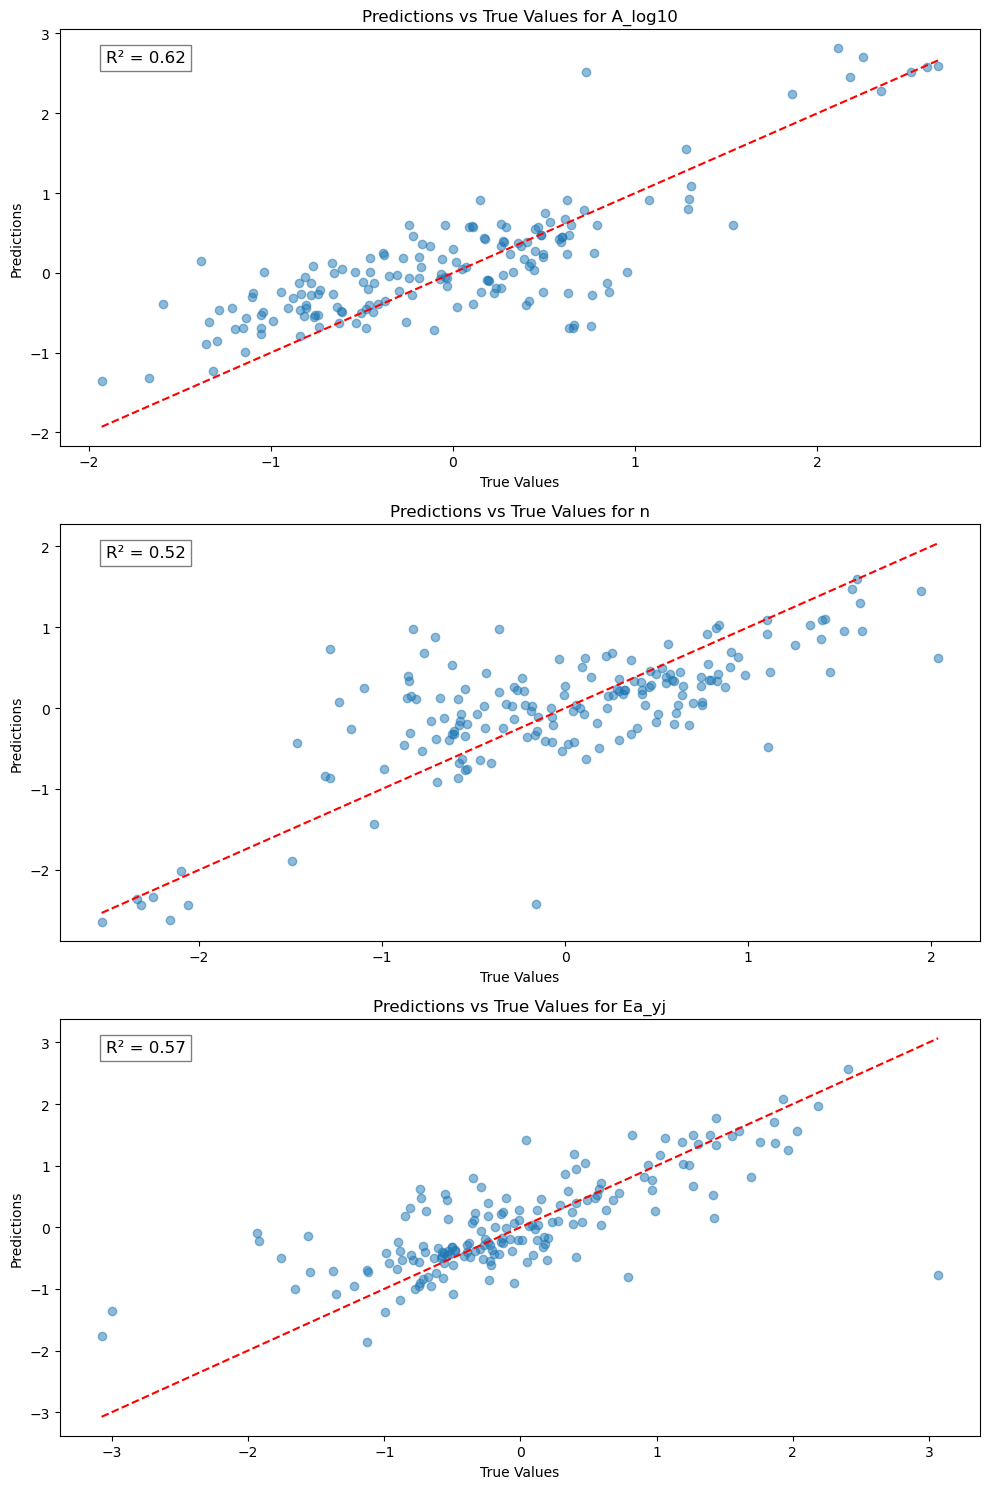

In [40]:
# Plot the predictions vs true values - also put r2 score on the plot

import matplotlib.pyplot as plt
def plot_predictions_vs_true(predictions, true_values, task_names):
    num_tasks = predictions.shape[1]
    fig, axes = plt.subplots(num_tasks, 1, figsize=(10, 5 * num_tasks))
    
    for i in range(num_tasks):
        ax = axes[i] if num_tasks > 1 else axes
        ax.scatter(true_values[:, i].cpu(), predictions[:, i].cpu(), alpha=0.5)
        ax.plot([true_values[:, i].min(), true_values[:, i].max()],
                [true_values[:, i].min(), true_values[:, i].max()], 'r--')
        r2 = R2Score()(predictions[:, i], true_values[:, i])
        ax.text(0.05, 0.95, f'R² = {r2:.2f}', transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
        ax.set_xlabel('True Values')
        ax.set_ylabel('Predictions')
        ax.set_title(f'Predictions vs True Values for {task_names[i]}')
    
    plt.tight_layout()
    plt.show()

task_names = ['A_log10', 'n', 'Ea_yj']
plot_predictions_vs_true(pred, true_y, task_names)
# Save the predictions and true values to a CSV file

In [41]:
pred_batches = trainer.predict(model, dataloaders=test_loader)
y_scaled = torch.cat(pred_batches, dim=0)          # shape (N, 3)

y_unscaled = model.inverse_transform(y_scaled)  # shape (N, 3)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [42]:
import torch
from torchmetrics.functional import mean_squared_error as mse_f
from torchmetrics.functional import mean_absolute_error as mae_f
from torchmetrics.functional import r2_score as r2_f

with torch.no_grad():
    # ── inverse-transform + A column back-transform ───────────────
    y_pred_unscaled  = model.inverse_transform(y_scaled.clone())
    y_true_unscaled  = model.inverse_transform(true_y.clone())

    # column 0 is log10(A) → exponentiate both preds & truth
    for tensor in (y_pred_unscaled, y_true_unscaled):
        tensor[:, 0] = torch.pow(10.0, tensor[:, 0])

    # ── overall metrics (all tasks at once) ───────────────────────
    mse_all = mse_f(y_pred_unscaled, y_true_unscaled)
    mae_all = mae_f(y_pred_unscaled, y_true_unscaled)
    r2_all  = r2_f (y_pred_unscaled, y_true_unscaled)
    print(f"Overall  MSE {mse_all:.4g}   MAE {mae_all:.4g}   R² {r2_all:.4g}")

    # ── per-task breakdown ────────────────────────────────────────
    task_names = ["A", "y₂", "y₃"]
    for i, name in enumerate(task_names):
        mse = mse_f(y_pred_unscaled[:, i], y_true_unscaled[:, i])
        mae = mae_f(y_pred_unscaled[:, i], y_true_unscaled[:, i])
        r2  = r2_f (y_pred_unscaled[:, i], y_true_unscaled[:, i])
        print(f"{name:>4}:   MSE {mse:.4g}   MAE {mae:.4g}   R² {r2:.4g}")


Overall  MSE 3.399e+10   MAE 1.313e+04   R² -1.929
   A:   MSE 1.02e+11   MAE 3.939e+04   R² -6.873
  y₂:   MSE 0.231   MAE 0.3594   R² 0.5219
  y₃:   MSE 0.4084   MAE 0.4276   R² 0.5655


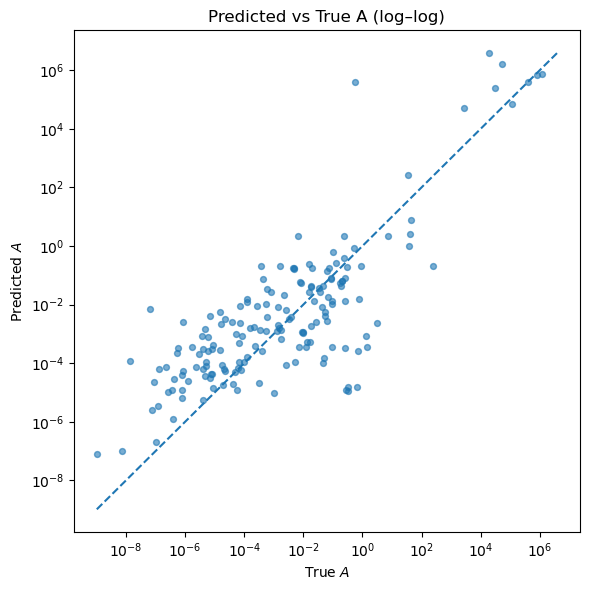

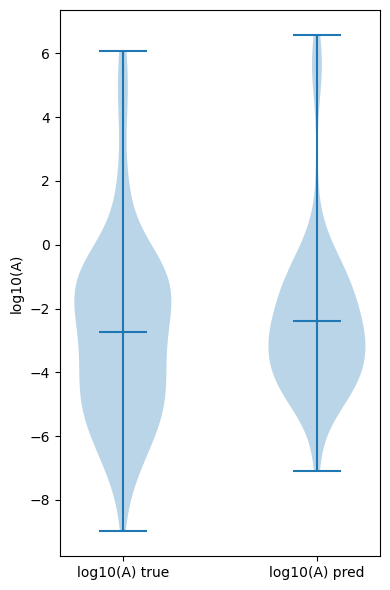

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# ------------- extract the first column (A) ----------------------
A_pred = y_pred_unscaled[:, 0].cpu().numpy()   # shape (N,)
A_true = y_true_unscaled[:, 0].cpu().numpy()   # shape (N,)

# ------------- scatter on log–log axes ---------------------------
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(A_true, A_pred, s=18, alpha=0.6)

lo, hi = A_true.min(), A_true.max()
lo = min(lo, A_pred.min())
hi = max(hi, A_pred.max())
ax.plot([lo, hi], [lo, hi], ls='--')           # identity line

ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel(r'True $A$'); ax.set_ylabel(r'Predicted $A$')
ax.set_title('Predicted vs True A (log–log)')
plt.tight_layout(); plt.show()

# ------------- optional violin plot of distributions -------------
fig, ax = plt.subplots(figsize=(4, 6))
ax.violinplot([np.log10(A_true), np.log10(A_pred)],
              positions=[1, 2], showmeans=True)
ax.set_xticks([1, 2], ['log10(A) true', 'log10(A) pred'])
ax.set_ylabel('log10(A)')
plt.tight_layout(); plt.show()


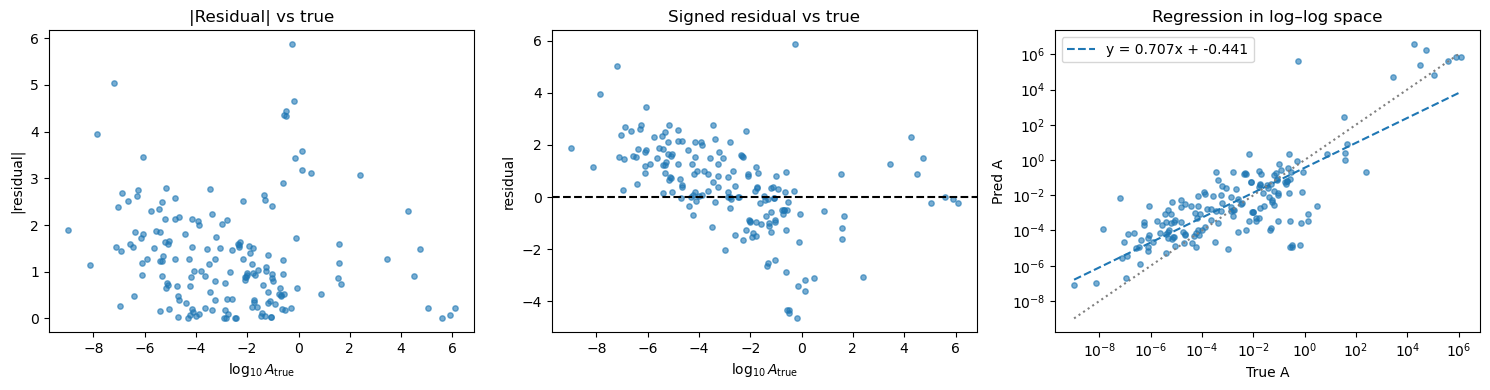

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# A_true, A_pred already exist as 1-D NumPy arrays
logA_true = np.log10(A_true)
logA_pred = np.log10(A_pred)

abs_resid = np.abs(logA_pred - logA_true)
sgn_resid = logA_pred - logA_true

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# ── Plot 1: |residual| vs true ─────────────────────────────────
axs[0].scatter(logA_true, abs_resid, s=15, alpha=0.6)
axs[0].set_xlabel(r'$\log_{10}A_{\mathrm{true}}$')
axs[0].set_ylabel(r'|residual|')
axs[0].set_title('|Residual| vs true')

# ── Plot 2: signed residual vs true ────────────────────────────
axs[1].scatter(logA_true, sgn_resid, s=15, alpha=0.6)
axs[1].axhline(0, ls='--', color='k')
axs[1].set_xlabel(r'$\log_{10}A_{\mathrm{true}}$')
axs[1].set_ylabel(r'residual')
axs[1].set_title('Signed residual vs true')

# ── Plot 3: log–log scatter + regression line ─────────────────
axs[2].scatter(A_true, A_pred, s=15, alpha=0.6)
reg = LinearRegression().fit(logA_true.reshape(-1,1), logA_pred)
slope, intercept = reg.coef_[0], reg.intercept_
x_line = np.linspace(logA_true.min(), logA_true.max(), 100)
axs[2].plot(10**x_line, 10**(intercept + slope*x_line), '--', label=f'y = {slope:.3f}x + {intercept:.3f}')
lo, hi = A_true.min(), A_true.max()
axs[2].plot([lo, hi], [lo, hi], ':', color='grey')        # identity
axs[2].set_xscale('log'); axs[2].set_yscale('log')
axs[2].set_xlabel('True A'); axs[2].set_ylabel('Pred A')
axs[2].legend()
axs[2].set_title('Regression in log–log space')

plt.tight_layout()
plt.show()


| Panel                              | What you see                                                                                                                                                              | Interpretation                                                                                                                       |
| ---------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------ |
| **1 • \|Residual\| vs log₁₀ A**    | Errors are low (≤1 log-unit) through most of the bulk ($-6\le\log_{10}A\le0$). They flare for the very smallest and very largest A values.                                | Model captures the mid-range but under-fits the extremes—typical when the loss is dominated by the dense centre of the distribution. |
| **2 • Signed residual vs log₁₀ A** | Points trend downward as A increases: negative residuals (under-prediction) for big A, positive (over-prediction) for tiny A.                                             | Systematic bias: the network compresses the dynamic range, pulling extremes toward the mean.                                         |
| **3 • Log–log regression**         | Best-fit line: **Pred ≈ 0.71 × True − 1.42** (dashed blue). The slope < 1 and negative intercept confirm attenuation + downward shift compared with the ideal grey $y=x$. | Same story numerically—about 30 % “flattening” of the true spread plus an overall under-prediction by \~1.4 log-units.               |
